In [4]:
import warnings
warnings.filterwarnings('always')
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import os

import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /home/naca11/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [5]:
df = pd.read_csv(os.path.join(path,os.listdir(path)[0]))

# Telco Customer Churn Dataset 컬럼 설명

## 기본 고객 정보
- **customerID** : 고객 고유 식별 ID  
- **gender** : 성별 (Male, Female)  
- **SeniorCitizen** : 시니어 여부 (0 = 아니오, 1 = 예)  
- **Partner** : 배우자 유무 (Yes, No)  
- **Dependents** : 부양가족 유무 (Yes, No)  

## 서비스 관련 정보
- **PhoneService** : 전화 서비스 가입 여부 (Yes, No)  
- **MultipleLines** : 복수 회선 사용 여부 (No, Yes, No phone service)  
- **InternetService** : 인터넷 서비스 제공 형태 (DSL, Fiber optic, No)  
- **OnlineSecurity** : 온라인 보안 서비스 (Yes, No, No internet service)  
- **OnlineBackup** : 온라인 백업 서비스 (Yes, No, No internet service)  
- **DeviceProtection** : 기기 보호 서비스 (Yes, No, No internet service)  
- **TechSupport** : 기술 지원 서비스 (Yes, No, No internet service)  
- **StreamingTV** : 스트리밍 TV 서비스 (Yes, No, No internet service)  
- **StreamingMovies** : 스트리밍 영화 서비스 (Yes, No, No internet service)  

## 계약 정보
- **Contract** : 계약 기간 (Month-to-month, One year, Two year)  
- **PaperlessBilling** : 전자 고지서 여부 (Yes, No)  
- **PaymentMethod** : 결제 방식  
  - Electronic check  
  - Mailed check  
  - Bank transfer (automatic)  
  - Credit card (automatic)  

## 요금 정보
- **MonthlyCharges** : 월 요금 (float)  
- **TotalCharges** : 총 청구 요금 (float, tenure × MonthlyCharges와 유사)  
- **tenure** : 서비스 이용 개월 수 (int)  

## 타겟 변수
- **Churn** : 고객 이탈 여부 (Yes, No)  


In [6]:
# 1-3) 기본 정보 & 샘플 확인
print("\n[info()]")
display(df.info())  # info()는 반환값이 None, 화면으로 출력됨

print("\n[head()]")
display(df.head())

# 1-4) 타깃(Churn) 값 분포 확인
print("\n[Churn value counts]")
display(df['Churn'].value_counts(dropna=False))
display(df['Churn'].value_counts(normalize=True)*100)


# 1-5) 결측치 개수 확인
print("\n[Missing values by column]")
print(df.isna().sum())


[info()]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null 

None


[head()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



[Churn value counts]


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


[Missing values by column]
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [21]:
df.drop(df[df['TotalCharges'] == ' '].index,inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype('float')

<Axes: xlabel='tenure', ylabel='MonthlyCharges'>

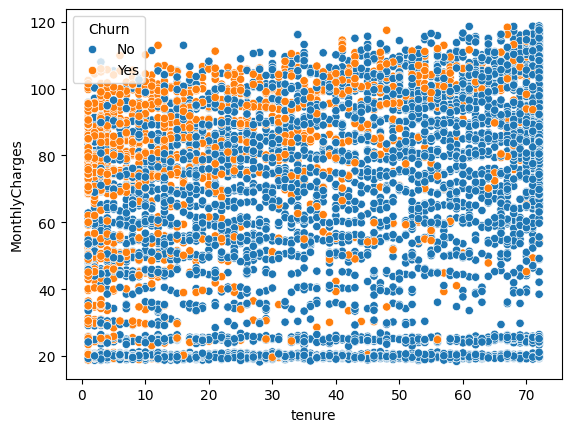

In [23]:
sns.scatterplot(data=df,x='tenure', y='MonthlyCharges', hue='Churn')